**Importing necessary libraries**



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
from sklearn.datasets import load_diabetes

In [5]:
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

**Loading the dataset**

**Diabetes Dataset Description:**

Features: 10 (numeric). In the sklearn copy these feature columns are standardized (approximately zero mean, unit variance).

Target: A continuous numeric value — a measure of disease progression (a higher number → greater progression) — used for regression tasks.

Features:

age — age of the patient (in the original dataset; in sklearn's version it is standardized).

sex — gender indicator (originally coded numerically).

bmi — body mass index.

bp — average blood pressure.

s1–s6 — six blood serum measurements (biochemical indicators).

In [6]:
X, y = load_diabetes(return_X_y=True)
print("Dataset shape:", X.shape)

Dataset shape: (442, 10)


## What is Generalization?
A model should not only fit the training data well, but also perform well on **unseen data**.

We'll demonstrate this by comparing training vs test scores.


In [7]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
models = {
    "Linear Regression": LinearRegression(),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print(f"{name}")
    print("Train R²:", round(r2_score(y_train, y_pred_train), 3))
    print("Test  R²:", round(r2_score(y_test, y_pred_test), 3))
    print('-'*21)


Linear Regression
Train R²: 0.524
Test  R²: 0.477
---------------------


##  k-Fold Cross-Validation
Instead of a single train/test split, we perform multiple splits and average results.


In [9]:
from sklearn.model_selection import cross_val_score, KFold

In [10]:
# Define model and CV strategy
model = LinearRegression()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print("Fold-wise R² scores:", np.round(scores, 3))
print("Average R²:", round(scores.mean(), 3))


Fold-wise R² scores: [0.453 0.573 0.391 0.584 0.391]
Average R²: 0.478


##  Model Selection via CV Scores
We compare multiple models using **cross-validation mean scores**.


In [11]:
from sklearn.preprocessing import PolynomialFeatures

In [12]:
# Define degrees to test
degrees = range(1, 6)
cv_results = []

In [13]:
# Perform CV for each polynomial degree
for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(X_train)

    model = LinearRegression()
    scores = cross_val_score(
        model, X_poly, y_train,
        cv=KFold(5, shuffle=True, random_state=42),
        scoring='r2'
    )

    cv_results.append({
        "Polynomial Degree": d,
        "Mean R²": scores.mean(),
        "Std Dev": scores.std()
    })

In [14]:
# Convert to DataFrame
df = pd.DataFrame(cv_results)
df.sort_values(by="Mean R²", ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

In [15]:
# Display CV results
print("Cross-Validation Results:")
display(df)

Cross-Validation Results:


,Polynomial Degree,Mean R²,Std Dev
0,1,0.468714,0.031005
1,2,0.100798,0.165899
2,5,-24.706901,11.724150
3,4,-24.795990,11.667560
4,3,-1196.214499,536.468930


**Degree 1:** Best performance — indicates that a linear model fits the data quite well.

**Degree 2:** Slightly worse — suggests mild overfitting begins with degree 2.

**Higher degree:** Severe Overfitting

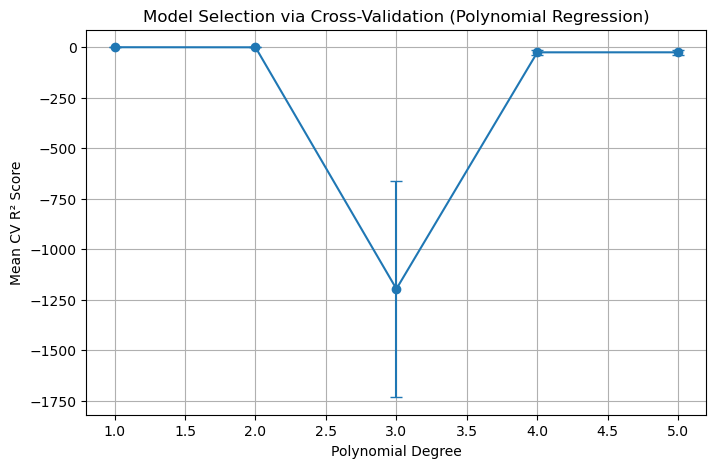

Best Polynomial Degree based on CV: 1.0


In [16]:
# Plot CV scores
plt.figure(figsize=(8,5))
plt.errorbar(degrees, [r['Mean R²'] for r in cv_results],
             yerr=[r['Std Dev'] for r in cv_results],
             fmt='-o', capsize=4)
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean CV R² Score")
plt.title("Model Selection via Cross-Validation (Polynomial Regression)")
plt.grid(True)
plt.show()

# Identify best degree
best_degree = df.iloc[0]["Polynomial Degree"]
print(f"Best Polynomial Degree based on CV: {best_degree}")

- The sharp dip for degree 3 indicates severe instability — the model fits noise rather than meaningful patterns.

- The linear model (degree = 1) is the best choice for the diabetes dataset.
Increasing polynomial degree leads to overfitting and drastically worse cross-validation performance.

### Interpretation:
Each model’s mean R² across 5 folds represents its **expected generalization performance**.  
- A higher **Mean R²** → better model.  
- A lower **Std Dev** → more stable performance.  
We usually pick the model with the **best balance of mean score and consistency**.


# **Bias-Variance Tradeoff with Fitted Curves**

Low degree polynomial → high bias (underfitting).

High degree polynomial → high variance (overfitting).

The validation set helps find the “sweet spot” where error is minimum.

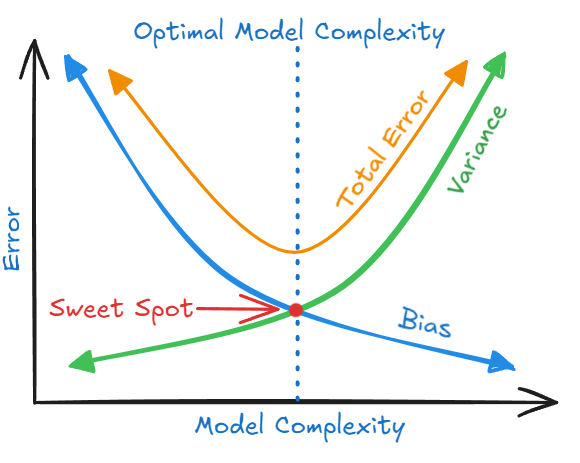

- The sweet spot in the bias-variance tradeoff is the point of optimal model complexity where both bias and variance are minimized,resulting in the lowest total error and the best generalization to new, unseen data.
- It's the balance achieved by making a model neither too simple (underfitting) nor too complex (overfitting), ensuring it captures underlying patterns without memorizing noise

In [17]:
#  Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 5, 50)
y = 2 * X**2 - 3 * X + 5 + np.random.randn(50) * 2  # add noise
X = X.reshape(-1, 1)
# X is 1D, but scikit-learn expects 2D arrays for features: (n_samples, n_features)
# reshape(-1, 1):
# -1 → “figure out the number of rows automatically” (here 50)
# 1 → one column (since we have one feature)

In [18]:
#  Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

We split twice because we want three separate datasets:

Training set (X_train, y_train) → used to train the model.

Validation set (X_val, y_val) → used to tune hyperparameters (like polynomial degree) and detect overfitting.

Test set (X_test, y_test) → used only at the very end to evaluate the final model’s performance on unseen data.

In [19]:
#  Degrees to visualize
degrees_to_plot = [1, 3, 10]  # underfit, good fit, overfit
X_range = np.linspace(0, 5, 200).reshape(-1, 1)

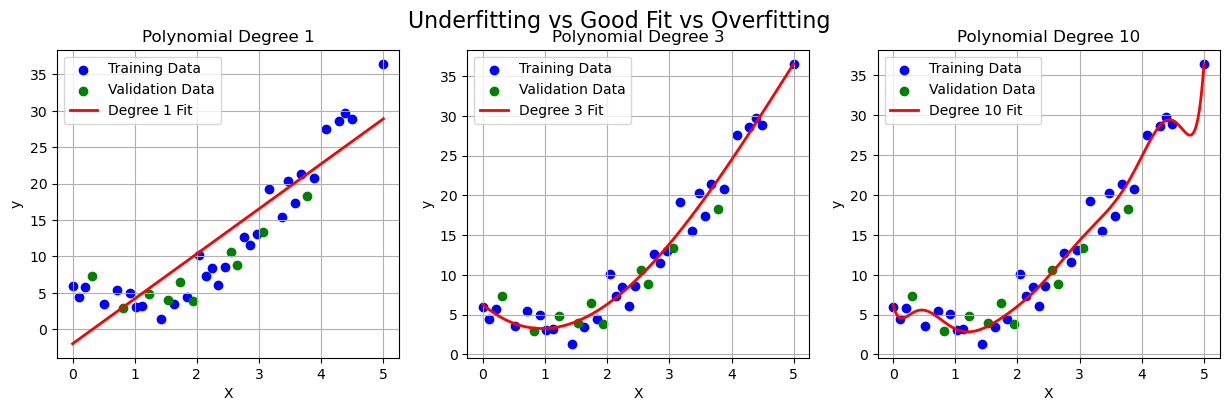

In [20]:
plt.figure(figsize=(15,4))

for i, d in enumerate(degrees_to_plot, 1):
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_range_poly = poly.transform(X_range)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_range_pred = model.predict(X_range_poly)

    plt.subplot(1, 3, i)
    plt.scatter(X_train, y_train, color='blue', label='Training Data')
    plt.scatter(X_val, y_val, color='green', label='Validation Data')
    plt.plot(X_range, y_range_pred, color='red', label=f'Degree {d} Fit', linewidth=2)
    plt.title(f"Polynomial Degree {d}")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)

plt.suptitle("Underfitting vs Good Fit vs Overfitting", fontsize=16)
plt.show()


Degree 1 (Underfit)

Straight line → fails to capture curve → high bias

Degree 3 (Good fit / Sweet Spot)

Fits data well without overfitting noise → balanced bias & variance

Degree 10 (Overfit)

Fits every data point → wiggly curve → high variance, poor generalization

**General trends:**

Underfitting (high bias): both Train and Val errors high at low degrees.

Good region: Val error low (often near its minimum) and Train–Val gap moderate.

Overfitting (high variance): Train error keeps dropping, Val error rises, and the Train–Val gap widens.

**Choose the degree**

Primary rule: pick the degree with the lowest Validation error.

If two are close, prefer the simpler model.

# **CROSS-VALIDATION **

In [21]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

In [22]:
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    LeaveOneOut,
    cross_val_score,
    GridSearchCV
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [23]:
# Load Classification Dataset

data = load_iris()
X = data.data # Features from Iris dataset
y = data.target # Target from Iris dataset (discrete labels)

print("Dataset shape:", X.shape)
print("Number of classes:", len(np.unique(y)))

Dataset shape: (150, 4)
Number of classes: 3


In [24]:
# HOLD-OUT VALIDATION (Train/Test Split)

print("--- Hold-Out Validation ---")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Train size:", X_train.shape[0], "| Test size:", X_test.shape[0])
print("Accuracy (Hold-out):", accuracy_score(y_test, y_pred))

--- Hold-Out Validation ---
Train size: 105 | Test size: 45
Accuracy (Hold-out): 0.9333333333333333


We split data into:
- 70% training
- 30% testing

Then train a **Logistic Regression** model and check test accuracy.
This is the simplest form of validation.

In [25]:
# HOLD-OUT VALIDATION (Train/Test/Validation Split)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.20, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Validation metrics
y_val_pred = model.predict(X_val)
print("Train size:", X_train.shape[0], "| Val size:", X_val.shape[0], "| Test size:", X_test.shape[0])
print("Accuracy (Validation):", accuracy_score(y_val, y_val_pred))

# Test metrics (final, once)
y_test_pred = model.predict(X_test)
print("Accuracy (Test):", accuracy_score(y_test, y_test_pred))







Train size: 84 | Val size: 21 | Test size: 45
Accuracy (Validation): 0.9523809523809523
Accuracy (Test): 1.0


In [26]:
#  K-FOLD CROSS VALIDATION
print("--- K-Fold Cross Validation ---")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf)
print("K-Fold scores:", scores)
print("Mean accuracy:", np.mean(scores))

--- K-Fold Cross Validation ---
K-Fold scores: [1.         1.         0.93333333 0.96666667 0.96666667]
Mean accuracy: 0.9733333333333334


We divide data into **K=5 folds**.
Each fold gets a turn as test data while the rest are used for training.
We average the accuracy scores across folds.

This reduces bias due to a single train/test split.

In [27]:
# STRATIFIED K-FOLD (Preserves Class Ratio)

print("--- Stratified K-Fold Cross Validation ---")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_strat = cross_val_score(model, X, y, cv=skf)
print("Stratified K-Fold scores:", scores_strat)
print("Mean accuracy:", np.mean(scores_strat))

--- Stratified K-Fold Cross Validation ---
Stratified K-Fold scores: [1.         0.96666667 0.93333333 1.         0.93333333]
Mean accuracy: 0.9666666666666668


Similar to K-Fold but ensures **each fold has the same class ratio** as the full dataset.
Useful for **classification problems** with imbalanced class distributions.

In [28]:
# LEAVE-ONE-OUT CROSS VALIDATION (LOOCV)
print("--- Leave-One-Out Cross Validation ---")

loo = LeaveOneOut()
scores_loo = cross_val_score(model, X, y, cv=loo)
print("Number of splits (LOOCV):", loo.get_n_splits(X))
print("Mean accuracy (LOOCV):", np.mean(scores_loo))


--- Leave-One-Out Cross Validation ---
Number of splits (LOOCV): 150
Mean accuracy (LOOCV): 0.9666666666666667


Here, **each sample acts as a test set once** and model trains on remaining samples.
This is the most exhaustive form of cross-validation but computationally expensive.

It will test equal to no of data sample times i.e. 150

 **GRIDSEARCHCV** (will be covered in detail in upcoming sessions)

`**GridSearchCV**` tests all combinations of hyperparameters using internal CV.
We'll tune Logistic Regression parameters:
- Regularization strength (`C`)
- Solver type (`liblinear` or `lbfgs`)
- Penalty (`l1`, `l2`)

It will find the **best combination** that gives highest accuracy.

In [29]:
# Define parameter grid for Logistic Regression
param_grid = [
    {'C': [0.1, 1, 10], 'solver': ['liblinear'], 'penalty': ['l1', 'l2']},
    {'C': [0.1, 1, 10], 'solver': ['lbfgs'], 'penalty': ['l2']} # lbfgs only supports l2
]

grid = GridSearchCV(LogisticRegression(max_iter=1000),
                    param_grid,
                    cv=5,
                    scoring='accuracy')


In [30]:
# Explicitly load the iris dataset again to ensure correct X and y for GridSearchCV
from sklearn.datasets import load_iris
data = load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
grid.fit(X, y)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)

# Compare best model performance
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Test Accuracy using Best Model:", accuracy_score(y_test, y_pred_best))

Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.9800000000000001
Test Accuracy using Best Model: 0.9777777777777777


In [31]:
# 7️⃣ Comparison Summary
print("\n--- Summary Comparison ---")
summary = pd.DataFrame({
    "CV Type": ["Hold-out", "K-Fold (5)", "Stratified K-Fold (5)", "LOOCV"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),
        np.mean(scores),
        np.mean(scores_strat),
        np.mean(scores_loo)
    ]
})
display(summary)


--- Summary Comparison ---


,CV Type,Accuracy
0,Hold-out,0.933333
1,K-Fold (5),0.973333
2,Stratified K-Fold (5),0.966667
3,LOOCV,0.966667


#  Comparing cross_val_score vs GridSearchCV

Now let's compare:
1. **cross_val_score** → performance of the default Logistic Regression.
2. **GridSearchCV** → performance of the best-tuned Logistic Regression.

We'll see how tuning parameters affects the CV accuracy.


In [32]:
# Base model (default Logistic Regression)
base_model = LogisticRegression(max_iter=1000)
base_cv_scores = cross_val_score(base_model, X, y, cv=5, scoring='accuracy')

# Results comparison
comparison_df = pd.DataFrame({
    "Method": ["cross_val_score ", "GridSearchCV "],
    "Mean CV Accuracy": [np.mean(base_cv_scores), grid.best_score_]
})

print("\n--- Comparison of Base vs Tuned Model ---")
display(comparison_df)



--- Comparison of Base vs Tuned Model ---


,Method,Mean CV Accuracy
0,cross_val_score,0.973333
1,GridSearchCV,0.980000


| Method                         | What It Shows                                                               |
| ------------------------------ | --------------------------------------------------------------------------- |
| `cross_val_score (Base Model)` | The average accuracy using **default** Logistic Regression parameters.      |
| `GridSearchCV (Best Model)`    | The average accuracy after **hyperparameter tuning** with cross-validation. |
